# Validation of Survey properties 

This survey generates quick `HEALPix` maps of different survey properties as a diagnostic. These properties are based on quantities from the coadd catalogs. For higher resolution/more comprehensive survey property maps we refer users to use `suprême`.

In [1]:
%pylab inline
import GCRCatalogs

Populating the interactive namespace from numpy and matplotlib


In [7]:
import healpy as hp

In [2]:
run = 'run2.2i'
release = 'dr6c'
gc = GCRCatalogs.load_catalog(f'dc2_object_{run}_{release}')

In [3]:
len(gc.available_tracts)

165

In [4]:
columns = ['ra', 'dec', 'cModelFlux_flag_g', 'cModelFlux_flag_r', 'cModelFlux_flag_i', 'mag_u', 'mag_g', 
           'mag_r', 'mag_i', 'mag_z', 'mag_y', 'snr_r_cModel', 'Ixx_r', 'Ixx_i', 'Ixy_r', 'Ixy_i', 'Iyy_r', 'Iyy_i', 
           'IxxPSF_r', 'IxxPSF_i', 'IxyPSF_r', 'IxyPSF_i', 'IyyPSF_r', 'IyyPSF_i','extendedness', 'blendedness']

In [5]:
filters = ['detect_isPrimary == True', 'mag_r < 28.5', 'base_PixelFlags_flag==False', 
           'base_PixelFlags_flag_bad==False', 'base_PixelFlags_flag_interpolated==False', 'extendedness==1']
snr_cut_prelim = ['snr_r_cModel > 7', 'snr_r_cModel < 13'] # We subselect this SNR range and avoid getting too many objects in memory at once
filters += snr_cut_prelim

In [6]:
data = gc.get_quantities(columns, filters=filters)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCR/base.py:438: RuntimeWarning: invalid value encountered in true_divide
  return modifier[0](*(native_quantities_loaded[_] for _ in modifier[1:]))


In [8]:
# Check how many galaxies there are in the sample
print(len(data['ra']))

28329794


In [9]:
nside=4096
data_map = np.bincount(hp.ang2pix(nside, data['ra'], data['dec'], lonlat=True),
                       minlength=12*nside**2)

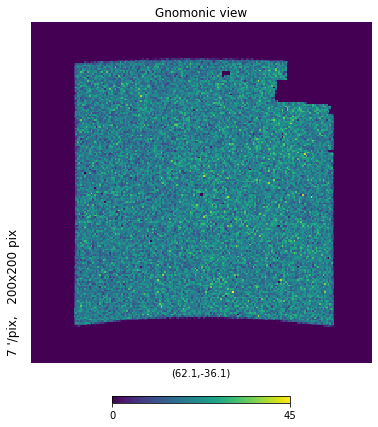

In [10]:
# First look at the map to see if there are any problems
hp.gnomview(data_map, rot=(62.1,-36.1), reso=7)

In [23]:
def compute_mean_qty(ra, dec, qty, nside=4096):
    """
    This routine computes the average magnitude in a given HEALPix pixel
    
    Inputs:
    -------
    ra: `numpy.ndarray` Right ascension (in degrees)
    dec: `numpy.ndarray` Declination (in degrees)
    mag: `numpy.ndarray` Quantity to qhich compute .
    
    Returns:
    --------
    hpmap: `numpy.ndarray` Map containing the mean magnitude as a function of
           position. This can be used as a proxy for n-sigma depth if mag is 
    """
    pxnum = hp.ang2pix(nside, ra, dec, lonlat=True)
    hpmap = np.bincount(pxnum, minlength=12*nside**2)
    qtymap = np.bincount(pxnum, weights=qty, minlength=12*nside**2)
    return qtymap/hpmap

## Depth

In [12]:
# Now we make an ad-hoc selection to get galaxies with an average of SNR~10
snr_range = (data['snr_r_cModel'] > 8) & (data['snr_r_cModel'] < 12.5) & (np.isfinite(data['mag_r'])) 

In [13]:
# We check that the mean SNR is close to 10
print(np.mean((data['snr_r_cModel'])[snr_range]))

9.979856844626372


In [14]:
# We get the mean magnitude for galaxies with SNR ~10 -- this is a good proxy for 10-sigma galaxy depth
depth_map = compute_mean_qty(data['ra'][snr_range], data['dec'][snr_range], data['mag_r'][snr_range])

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


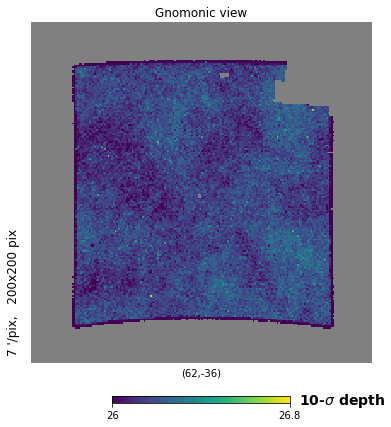

In [40]:
hp.gnomview(depth_map, rot=(62,-36), reso=7, unit=r'10-$\sigma$ depth', min=26, max=26.8)

In [ ]:
# You can write the map if you'd like to
#output_path = 'test_map.fits.gz'
#hp.write_map(output_path, depth_map)

(25.8, 26.5)

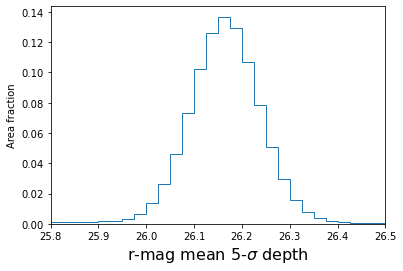

In [21]:
# Let's also check the 1D distribution of the depth
plt.hist(depth_map, range=(25,27.5), bins=100, histtype='step', weights=1./np.count_nonzero(depth_map>0)*np.ones_like(depth_map));
plt.xlabel(r'r-mag mean 5-$\sigma$ depth', fontsize=16)
plt.ylabel('Area fraction')
plt.xlim(25.8, 26.5)

## PSF Size

In [25]:
T = 0.2**2*(data['IxxPSF_r']+data['IyyPSF_r'])
# Select objects with good SNR but not too bright
T_cut = (np.fabs(T) < 10) & (data['snr_r_cModel'] > 10) & (data['snr_r_cModel'] < 200)
T_map = compute_mean_qty(data['ra'][T_cut], data['dec'][T_cut], T[T_cut])

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


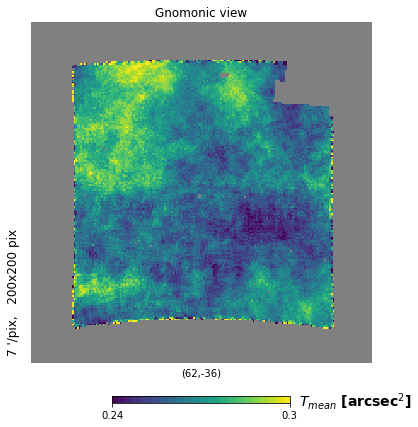

In [26]:
hp.gnomview(T_map, rot=(62,-36), reso=7, unit=r'$T_{mean}$ [arcsec$^{2}$]', min=0.24, max=0.30)

Text(0, 0.5, 'Area fraction')

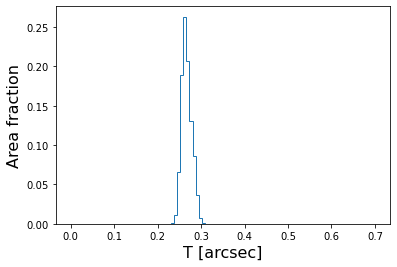

In [27]:
plt.hist(T, bins=100, histtype='step', weights=np.ones(len(T))/np.count_nonzero(T>0))
plt.xlabel('T [arcsec]', fontsize=16)
plt.ylabel('Area fraction', fontsize=16)

## PSF Ellipticity

In [29]:
# The stack uses the distortion definition for shear. It is useful to also use the shear definition
def asymQ(ixx,iyy,ixy):
    asymQx = ixx - iyy
    asymQy = 2*ixy
    return np.sqrt(asymQx**2 + asymQy**2)
def trQ(ixx,iyy):
    return ixx+iyy
def get_a(ixx,iyy,ixy):
    return np.sqrt(0.5*(trQ(ixx,iyy)+asymQ(ixx,iyy,ixy)))
def get_b(ixx,iyy,ixy):
    return np.sqrt(0.5*(trQ(ixx,iyy)-asymQ(ixx,iyy,ixy)))
def get_e(ixx,iyy,ixy):
    a = get_a(ixx,iyy,ixy)
    b = get_b(ixx,iyy,ixy)
    return (a**2-b**2)/(a**2+b**2)

In [30]:
e_PSF = get_e(data['IxxPSF_r'], data['IyyPSF_r'], data['IxyPSF_r'])
# Select objects where the PSF ellipticity estimation was sensible
e_cut = np.fabs(e_PSF) < 10
e_map = compute_mean_qty(data['ra'][e_cut], data['dec'][e_cut], e_PSF[e_cut])

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


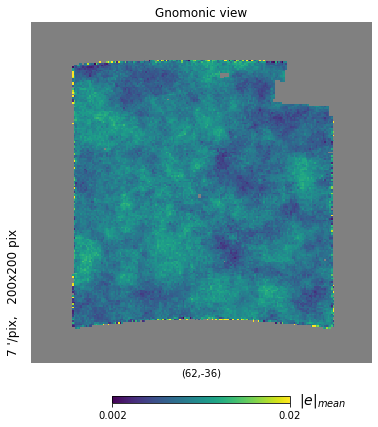

In [31]:
hp.gnomview(e_map, rot=(62,-36), reso=7, unit=r'$|e|_{mean}$', max=0.02, min=0.002)

(0.0, 0.02)

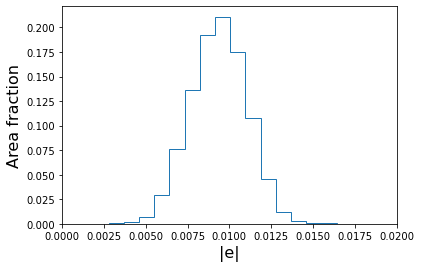

In [33]:
plt.hist(e_PSF, bins=100, histtype='step', weights=np.ones(len(e_PSF))/np.count_nonzero(e_PSF>0))
plt.xlabel('|e|', fontsize=16)
plt.ylabel('Area fraction', fontsize=16)
plt.xlim(0, 0.02)

In [34]:
def get_e1_e2(ixx, iyy, ixy):
    trQ = ixx+iyy
    detQ = ixx*iyy-ixy**2
    asymQx = ixx - iyy
    asymQy = 2*ixy
    e_denom = trQ + 2*np.sqrt(detQ)
    e1 = asymQx/e_denom
    e2 = asymQy/e_denom
    return e1, e2

In [36]:
e1_PSF, e2_PSF = get_e1_e2(data['IxxPSF_r'], data['IyyPSF_r'], data['IxyPSF_r'])
# Get objects where the PSF ellipticity is sensible and have good SNR
e12_cut = (np.fabs(e2_PSF) < 10) & (np.fabs(e1_PSF) < 10) & (data['snr_r_cModel']>10)
e1_map = compute_mean_qty(data['ra'][e12_cut], data['dec'][e12_cut], e1_PSF[e12_cut], nside=1024)
e2_map = compute_mean_qty(data['ra'][e12_cut], data['dec'][e12_cut], e2_PSF[e12_cut], nside=1024)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


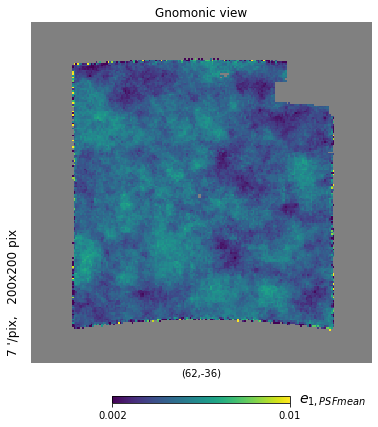

In [37]:
hp.gnomview(e1_map, rot=(62,-36), reso=7, unit=r'$e_{1, PSF mean}$', min=0.002, max=0.01)

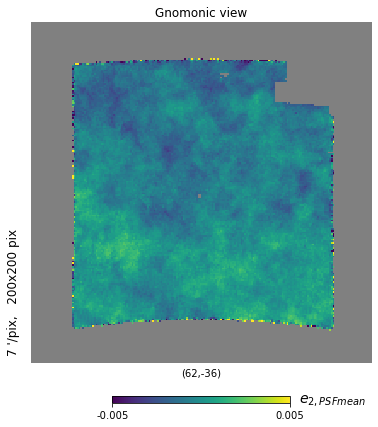

In [38]:
hp.gnomview(e2_map, rot=(62,-36), reso=7, unit=r'$e_{2, PSF mean}$', max=0.005, min=-0.005)

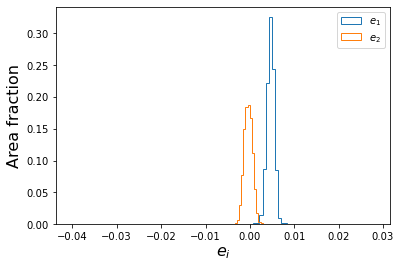

In [39]:
plt.hist(e1_map, bins=100, weights=np.ones(len(e1_map))/np.count_nonzero(e1_map>-10), histtype='step', label='$e_{1}$')
plt.hist(e2_map, bins=100, weights=np.ones(len(e1_map))/np.count_nonzero(e2_map>-10), histtype='step', label='$e_{2}$')
plt.xlabel('$e_{i}$', fontsize=16)
plt.ylabel('Area fraction', fontsize=16)
plt.legend(loc='best')